In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import gc
import os
import time
import pickle

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [5]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras import metrics

from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.layers import GlobalMaxPooling1D

In [6]:
final_df = pd.read_csv('./consolidated_4_10pct_sample_new.csv')
final_df.shape

(1243426, 66)

In [7]:
def split_train_test(data, features):
    indexer = data[['s2_cell_id','measure_date']].copy()
    train = data[data.measure_date < '2018-01-01'].copy()
    test = data[data.measure_date >= '2018-01-01'].copy()
    
    y_train = train.wf_wildfire.copy().values
    y_test = test.wf_wildfire.copy().values    
    
    y_train_ext = train.wf_wildfire_ext.copy().values
    y_test_ext = test.wf_wildfire_ext.copy().values    

    train = train[features]
    test = test[features]    
    
    test_ids = data[data.measure_date >= '2018-01-01'][['s2_cell_id', 'measure_date']]
    
    return train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Prints and plots the confusion matrix.

    Args:
        y_true: list of true target labels
        y_pred: list of predicted target labels
        classes: tuple of class labels in 0, 1 order

    Kwargs:
        normalize: bool, normalize confusion matrix or not
        cmap: color map
    """

    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix, without normalization')
    print(cm)

    print(classification_report(y_true, y_pred, target_names=classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

In [9]:
def bin_prob(probs, y_test):
    y_binned = np.digitize(probs, np.arange(0,1.1,0.1))
    bin_df = pd.DataFrame(list(zip(y_test, probs, y_binned)), columns =['Actual', 'Prob', 'Bin'])
    bin_df = bin_df.groupby('Bin').agg({'Actual': ['mean', 'sum', 'count'], 'Prob': 'mean'})
    return bin_df

In [10]:
class TimeHistory(tf.keras.callbacks.Callback):
    """
    https://stackoverflow.com/questions/43178668/
    record-the-computation-time-for-each-epoch-in-keras-during-model-fit
    """

    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
def mlp_model(layers, units, dropout_rate, input_shape, op_units, op_activation):
    """
    Creates an instance of a multi-layer perceptron model.

    Arguments
      layers: int, number of `Dense` layers in the model.
      units: int, output dimension of the layers.
      dropout_rate: float, percentage of input to drop at Dropout layers.
      input_shape: tuple, shape of input to the model.
      op_units: number of output units (1 for binary target)
      op_activation: activation function (sigmoid for binary target)

    Returns
      An MLP model instance.
    """

    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers - 1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))

    return model

In [12]:
def train_model(data,
                model_type='cnn',
                learning_rate=1e-3,
                epochs=1000,
                batch_size=128,
                blocks=2,
                filters=64,
                layers=2,
                units=64,
                dropout_rate=0.2,
                kernel_size=3,
                pool_size=3,
                num_classes=2,
                class_weights={0:1.,1:1.}):
    """
    Trains sequence model on the given dataset.

    Args:
      data: tuples of vectorized training and test texts and labels.
      log_dir: directory to write logs to

    Kwargs:
      model_type: str, type of model to train
      word_index: word_index if applicable
      learning_rate: float, learning rate for training model.
      epochs: int, number of epochs.
      batch_size: int, number of samples per batch.
      blocks: int, number of pairs of sepCNN and pooling blocks in the model.
      filters: int, output dimension of sepCNN layers in the model.
      dropout_rate: float: percentage of input to drop at Dropout layers.
      embedding_dim: int, dimension of the embedding vectors.
      kernel_size: int, length of the convolution window.
      pool_size: int, factor by which to downscale input at MaxPooling layer.
      max_num_words: int, max number of features to use
      num_classes: int, number of classes in the target variable
      use_pretrained_embedding: bool, use pretrained embeddings or no
      is_embedding_trainable: bool, train embeddings or no
      use_word_embedding: bool, False if sentence encodding is used
      glove_dir: directory with glove embeddings if applicable
    """

    # Get the data.
    x_train, train_labels, x_val, val_labels = data

    if num_classes == 2:
        op_units, op_activation = 1, 'sigmoid'
    else:
        op_units, op_activation = num_classes, 'softmax'

    # Create model instance.
    if model_type == 'cnn':
        model = cnn_model(filters=filters,
                          kernel_size=kernel_size,
                          layers=layers,
                          dropout_rate=dropout_rate,
                          pool_size=pool_size,
                          input_shape=x_train.shape[1:],
                          op_units=op_units,
                          op_activation=op_activation)
    elif model_type == 'mlp':
        model = mlp_model(layers=layers,
                          units=units,
                          dropout_rate=dropout_rate,
                          input_shape=x_train.shape[1:],
                          op_units=op_units,
                          op_activation=op_activation)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
#     optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate) - didn't work (too many false negatives)
#     optimizer = tf.keras.optimizers.SGD(lr=learning_rate) - similar performance to Adam
#     optimizer = tf.keras.optimizers.Adagrad(lr=learning_rate) - didn't work (too many false positives)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[metrics.Recall()])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [
#           tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            patience=2),
          TimeHistory()]

    # Train and validate model.
    history = model.fit(
      x_train,
      train_labels,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=(x_val, val_labels),
      verbose=2,  # Logs once per epoch.
      batch_size=batch_size,
      class_weight=class_weights)

    train_pred_probs = model.predict(x_train)
    val_pred_probs = model.predict(x_val)

    return history.history, model, train_pred_probs, val_pred_probs

In [13]:
scaler = MinMaxScaler()

## Optimizer: Adam; Features: - precipitation

In [14]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
 'relative_humidity_mean_l1',
 'wea_air_temp_mean_ma30',
 'relative_humidity_mean_ma30'
]

fuel_features = [
 'fuel_percent',
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
]

In [90]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + fuel_features
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

In [91]:
train.shape, test.shape

((825325, 33), (418101, 33))

In [92]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [93]:
pickle.dump(scaler, open('./Models/scaler_10pct_noprecip_cwEQ_ext_new', 'wb'))

In [21]:
cw = class_weight.compute_class_weight('balanced', np.unique(y_train_ext), y_train_ext)
cw

array([0.53436733, 7.77435004])

In [22]:
model_params = {
    'model_type': 'mlp',
    'learning_rate': 1e-3,
    'epochs': 20,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2,
    'class_weights': {0: cw[0], 1: cw[1]}
}

In [53]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Train on 825325 samples, validate on 418101 samples
Epoch 1/20
 - 12s - loss: 0.5769 - recall_3: 0.7440 - val_loss: 0.7728 - val_recall_3: 0.9326
Epoch 2/20
 - 10s - loss: 0.5379 - recall_3: 0.8020 - val_loss: 0.8679 - val_recall_3: 0.9504
Epoch 3/20
 - 11s - loss: 0.5288 - recall_3: 0.8086 - val_loss: 0.6840 - val_recall_3: 0.8965
Epoch 4/20
 - 11s - loss: 0.5224 - recall_3: 0.8097 - val_loss: 0.7920 - val_recall_3: 0.9379
Epoch 5/20
 - 11s - loss: 0.5195 - recall_3: 0.8117 - val_loss: 0.7965 - val_recall_3: 0.9280
Epoch 6/20
 - 11s - loss: 0.5174 - recall_3: 0.8135 - val_loss: 0.8143 - val_recall_3: 0.9203
Epoch 7/20
 - 11s - loss: 0.5159 - recall_3: 0.8129 - val_loss: 0.8250 - val_recall_3: 0.9441
Epoch 8/20
 - 11s - loss: 0.5147 - recall_3: 0.8146 - val_loss: 0.8039 - val_recall_3: 0.9352
Epoch 9/20
 - 11s - loss: 0.5139 - recall_3: 0.8143 - val_loss: 0.8203 - val_recall_3: 0.9352
Epoch 10/20
 - 11s - loss: 0.5117 - recall_3: 0.8182 - val_loss: 0.7646 - val_recall_3: 0.9276
Epoch 1

In [54]:
model_mlp.save('./Models/mlp_adam_noprecip_cwEQ_ext_new.h5')

In [55]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000170    4.0  23476  0.044769
2    0.000984   22.0  22369  0.151870
3    0.001832   57.0  31108  0.253647
4    0.002049  102.0  49777  0.353970
5    0.002862  207.0  72325  0.452065
6    0.003324  287.0  86334  0.550671
7    0.004493  389.0  86583  0.648066
8    0.003826  167.0  43647  0.736859
9    0.002872    7.0   2437  0.816676
10   0.000000    0.0     28  0.986070
11   0.000000    0.0     17  1.000000

In [56]:
test_preds = test_pred_probs[:,0]>0.5
test_preds.sum()

219046

Confusion matrix, without normalization
[[198663 218196]
 [   392    850]]
              precision    recall  f1-score   support

         nwf       1.00      0.48      0.65    416859
          wf       0.00      0.68      0.01      1242

   micro avg       0.48      0.48      0.48    418101
   macro avg       0.50      0.58      0.33    418101
weighted avg       1.00      0.48      0.64    418101



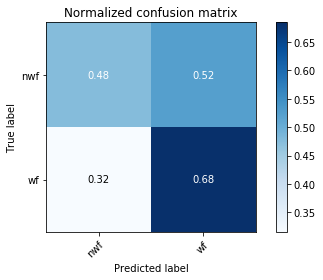

In [57]:
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

## Testing new features

In [16]:
new_tl_features = [
    'tl_s2_cells_lvl16_cnt',
    'tl_s2_cells_lvl16_cnt_coverage'
]

new_control_features = [
 'fz_grp_high',
 'fz_grp_low',
 'fz_grp_med'
]

new_sat_feature = [
  'sat_faparval_median',
  'sat_faparval_undefined'
]

precip_cut50 = [
    'wea_precip_accum_max_cut50',
    'wea_precip_accum_max_ma7_cut50',
    'wea_precip_accum_max_ma30_cut50',
    'wea_precip_accum_max_l1_cut50'
]

precip_cut70 = [
    'wea_precip_accum_max_cut70',
    'wea_precip_accum_max_ma7_cut70',
    'wea_precip_accum_max_ma30_cut70',
    'wea_precip_accum_max_l1_cut70'
]

precip_cut90 = [
    'wea_precip_accum_max_cut90',
    'wea_precip_accum_max_ma7_cut90',
    'wea_precip_accum_max_ma30_cut90',
    'wea_precip_accum_max_l1_cut90'
]

### + Fire Zones Controls

In [88]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + fuel_features + new_control_features
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [89]:
pickle.dump(scaler, open('./Models/scaler_10pct_noprecip_cwEQ_ext_fz', 'wb'))

In [39]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Train on 825325 samples, validate on 418101 samples
Epoch 1/20
 - 11s - loss: 0.5827 - recall_2: 0.7316 - val_loss: 0.6914 - val_recall_2: 0.9001
Epoch 2/20
 - 10s - loss: 0.5422 - recall_2: 0.7942 - val_loss: 0.7556 - val_recall_2: 0.9205
Epoch 3/20
 - 10s - loss: 0.5297 - recall_2: 0.8048 - val_loss: 0.8345 - val_recall_2: 0.9538
Epoch 4/20
 - 10s - loss: 0.5245 - recall_2: 0.8085 - val_loss: 0.9352 - val_recall_2: 0.9465
Epoch 5/20
 - 10s - loss: 0.5207 - recall_2: 0.8121 - val_loss: 0.8612 - val_recall_2: 0.9418
Epoch 6/20
 - 10s - loss: 0.5168 - recall_2: 0.8150 - val_loss: 0.8153 - val_recall_2: 0.9404
Epoch 7/20
 - 10s - loss: 0.5161 - recall_2: 0.8139 - val_loss: 0.8786 - val_recall_2: 0.9489
Epoch 8/20
 - 10s - loss: 0.5142 - recall_2: 0.8176 - val_loss: 0.8185 - val_recall_2: 0.9408
Epoch 9/20
 - 10s - loss: 0.5130 - recall_2: 0.8190 - val_loss: 0.6872 - val_recall_2: 0.9168
Epoch 10/20
 - 10s - loss: 0.5124 - recall_2: 0.8178 - val_loss: 0.7606 - val_recall_2: 0.9351
Epoch 1

In [47]:
model_mlp.save('./Models/mlp_adam_noprecip_cwEQ_ext_fz.h5')

In [44]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000291    7.0  24020  0.048960
2    0.000876   22.0  25119  0.152044
3    0.001832   62.0  33844  0.252357
4    0.002189  100.0  45678  0.352245
5    0.003074  179.0  58239  0.451574
6    0.003494  242.0  69260  0.551034
7    0.003897  289.0  74153  0.648800
8    0.004031  272.0  67469  0.747980
9    0.003417   69.0  20191  0.828555
10   0.000000    0.0    114  0.920248
11   0.000000    0.0     14  1.000000

In [45]:
test_preds = test_pred_probs[:,0]>0.5
test_preds.sum()

231201

Confusion matrix, without normalization
[[186530 230329]
 [   370    872]]
              precision    recall  f1-score   support

         nwf       1.00      0.45      0.62    416859
          wf       0.00      0.70      0.01      1242

   micro avg       0.45      0.45      0.45    418101
   macro avg       0.50      0.57      0.31    418101
weighted avg       1.00      0.45      0.62    418101



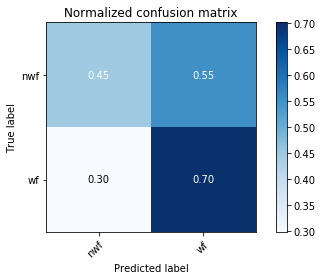

In [46]:
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

In [43]:
gc.collect()

200

### + Precipitation cut at 50% humidity

In [86]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut50
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [87]:
pickle.dump(scaler, open('./Models/scaler_10pct_precip50_cwEQ_ext_new', 'wb'))

In [59]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Train on 825325 samples, validate on 418101 samples
Epoch 1/20
 - 12s - loss: 0.5692 - recall_4: 0.7477 - val_loss: 0.7413 - val_recall_4: 0.8735
Epoch 2/20
 - 11s - loss: 0.5205 - recall_4: 0.7946 - val_loss: 0.7373 - val_recall_4: 0.8702
Epoch 3/20
 - 11s - loss: 0.5065 - recall_4: 0.8045 - val_loss: 0.6333 - val_recall_4: 0.8471
Epoch 4/20
 - 11s - loss: 0.5000 - recall_4: 0.8071 - val_loss: 0.7067 - val_recall_4: 0.8591
Epoch 5/20
 - 11s - loss: 0.4956 - recall_4: 0.8104 - val_loss: 0.7190 - val_recall_4: 0.8942
Epoch 6/20
 - 11s - loss: 0.4904 - recall_4: 0.8171 - val_loss: 0.7203 - val_recall_4: 0.8984
Epoch 7/20
 - 11s - loss: 0.4890 - recall_4: 0.8165 - val_loss: 0.6502 - val_recall_4: 0.8805
Epoch 8/20
 - 11s - loss: 0.4865 - recall_4: 0.8168 - val_loss: 0.6332 - val_recall_4: 0.8750
Epoch 9/20
 - 11s - loss: 0.4850 - recall_4: 0.8190 - val_loss: 0.6735 - val_recall_4: 0.8924
Epoch 10/20
 - 11s - loss: 0.4830 - recall_4: 0.8215 - val_loss: 0.7285 - val_recall_4: 0.8996
Epoch 1

In [63]:
model_mlp.save('./Models/mlp_adam_precip50_cwEQ_ext_new.h5')

In [61]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000163    5.0  30686  0.050988
2    0.000881   26.0  29520  0.151603
3    0.001228   49.0  39892  0.252794
4    0.001557   82.0  52673  0.351697
5    0.002516  160.0  63597  0.450794
6    0.003554  234.0  65839  0.550241
7    0.005050  326.0  64551  0.650138
8    0.005184  303.0  58450  0.744999
9    0.004550   57.0  12527  0.829995
10   0.000000    0.0    355  0.947721
11   0.000000    0.0     11  1.000000

Confusion matrix, without normalization
[[216046 200813]
 [   322    920]]
              precision    recall  f1-score   support

         nwf       1.00      0.52      0.68    416859
          wf       0.00      0.74      0.01      1242

   micro avg       0.52      0.52      0.52    418101
   macro avg       0.50      0.63      0.35    418101
weighted avg       1.00      0.52      0.68    418101



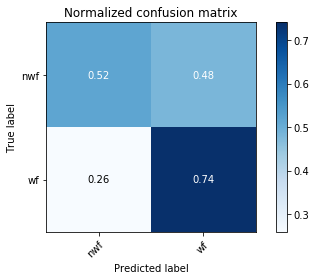

In [62]:
test_preds = test_pred_probs[:,0]>0.5
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

### + Precipitation cut at 70% humidity

In [84]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut70
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [85]:
pickle.dump(scaler, open('./Models/scaler_10pct_precip70_cwEQ_ext_new', 'wb'))

In [65]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Train on 825325 samples, validate on 418101 samples
Epoch 1/20
 - 12s - loss: 0.5683 - recall_5: 0.7610 - val_loss: 0.6439 - val_recall_5: 0.8856
Epoch 2/20
 - 12s - loss: 0.5262 - recall_5: 0.8048 - val_loss: 0.5967 - val_recall_5: 0.8556
Epoch 3/20
 - 11s - loss: 0.5123 - recall_5: 0.8115 - val_loss: 0.6423 - val_recall_5: 0.8733
Epoch 4/20
 - 11s - loss: 0.5053 - recall_5: 0.8152 - val_loss: 0.7396 - val_recall_5: 0.9072
Epoch 5/20
 - 11s - loss: 0.5021 - recall_5: 0.8196 - val_loss: 0.6921 - val_recall_5: 0.8826
Epoch 6/20
 - 11s - loss: 0.5002 - recall_5: 0.8193 - val_loss: 0.6029 - val_recall_5: 0.8529
Epoch 7/20
 - 11s - loss: 0.4965 - recall_5: 0.8204 - val_loss: 0.7734 - val_recall_5: 0.9218
Epoch 8/20
 - 11s - loss: 0.4945 - recall_5: 0.8231 - val_loss: 0.7095 - val_recall_5: 0.9044
Epoch 9/20
 - 11s - loss: 0.4925 - recall_5: 0.8220 - val_loss: 0.7125 - val_recall_5: 0.9047
Epoch 10/20
 - 11s - loss: 0.4910 - recall_5: 0.8256 - val_loss: 0.7144 - val_recall_5: 0.9061
Epoch 1

In [68]:
model_mlp.save('./Models/mlp_adam_precip70_cwEQ_ext_new.h5')

In [66]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000157    4.0  25522  0.050439
2    0.000667   18.0  26990  0.152859
3    0.001010   45.0  44538  0.254943
4    0.001531   90.0  58786  0.349348
5    0.002515  138.0  54864  0.450432
6    0.004260  275.0  64547  0.551397
7    0.004979  375.0  75309  0.652222
8    0.004418  259.0  58623  0.740377
9    0.004323   38.0   8791  0.826060
10   0.000000    0.0    116  0.949955
11   0.000000    0.0     15  1.000000

Confusion matrix, without normalization
[[210405 206454]
 [   295    947]]
              precision    recall  f1-score   support

         nwf       1.00      0.50      0.67    416859
          wf       0.00      0.76      0.01      1242

   micro avg       0.51      0.51      0.51    418101
   macro avg       0.50      0.63      0.34    418101
weighted avg       1.00      0.51      0.67    418101



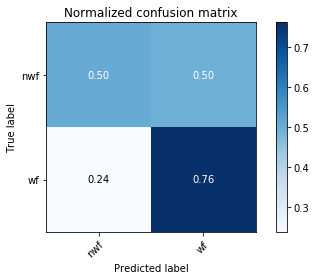

In [67]:
test_preds = test_pred_probs[:,0]>0.5
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

### + Precipitation cut at 90% humidity

In [82]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut90
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [83]:
pickle.dump(scaler, open('./Models/scaler_10pct_precip90_cwEQ_ext_new', 'wb'))

In [70]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Train on 825325 samples, validate on 418101 samples
Epoch 1/20
 - 11s - loss: 0.5763 - recall_6: 0.7466 - val_loss: 0.7438 - val_recall_6: 0.9273
Epoch 2/20
 - 11s - loss: 0.5382 - recall_6: 0.8054 - val_loss: 0.8523 - val_recall_6: 0.9423
Epoch 3/20
 - 11s - loss: 0.5262 - recall_6: 0.8101 - val_loss: 0.7198 - val_recall_6: 0.9138
Epoch 4/20
 - 11s - loss: 0.5197 - recall_6: 0.8123 - val_loss: 0.8024 - val_recall_6: 0.9491
Epoch 5/20
 - 11s - loss: 0.5168 - recall_6: 0.8117 - val_loss: 0.7657 - val_recall_6: 0.9287
Epoch 6/20
 - 11s - loss: 0.5154 - recall_6: 0.8159 - val_loss: 0.7124 - val_recall_6: 0.9044
Epoch 7/20
 - 11s - loss: 0.5128 - recall_6: 0.8143 - val_loss: 0.7173 - val_recall_6: 0.9180
Epoch 8/20
 - 11s - loss: 0.5123 - recall_6: 0.8172 - val_loss: 0.7528 - val_recall_6: 0.9201
Epoch 9/20
 - 11s - loss: 0.5114 - recall_6: 0.8155 - val_loss: 0.7772 - val_recall_6: 0.9315
Epoch 10/20
 - 11s - loss: 0.5100 - recall_6: 0.8174 - val_loss: 0.8004 - val_recall_6: 0.9261
Epoch 1

In [73]:
model_mlp.save('./Models/mlp_adam_precip90_cwEQ_ext_new.h5')

In [71]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000295    7.0  23703  0.046321
2    0.000882   22.0  24931  0.151393
3    0.001595   54.0  33853  0.253466
4    0.002093  108.0  51604  0.353024
5    0.002814  190.0  67523  0.451563
6    0.003345  263.0  78630  0.550667
7    0.004402  363.0  82458  0.649436
8    0.004138  209.0  50510  0.740790
9    0.005374   26.0   4838  0.821879
10   0.000000    0.0     34  0.967859
11   0.000000    0.0     17  1.000000

Confusion matrix, without normalization
[[201233 215626]
 [   381    861]]
              precision    recall  f1-score   support

         nwf       1.00      0.48      0.65    416859
          wf       0.00      0.69      0.01      1242

   micro avg       0.48      0.48      0.48    418101
   macro avg       0.50      0.59      0.33    418101
weighted avg       1.00      0.48      0.65    418101



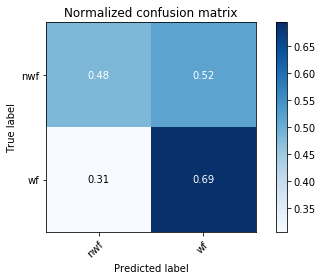

In [72]:
test_preds = test_pred_probs[:,0]>0.5
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

### + The Rest

In [17]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut50 + new_tl_features + new_control_features + ['sat_faparval_median']
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [18]:
pickle.dump(scaler, open('./Models/scaler_10pct_precip50_cwEQ_ext_other', 'wb'))

In [23]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 825325 samples, validate on 418101 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 11s - loss: 0.5708 - recall: 0.7366 - val_loss: 0.6452 - val_recall: 0.8319
Epoch 2/20
 - 10s - loss: 0.5219 - recall: 0.7894 - val_loss: 0.6585 - val_recall: 0.8489
Epoch 3/20
 - 11s - loss: 0.5056 - recall: 0.8061 - val_loss: 0.6578 - val_recall: 0.8443
Epoch 4/20
 - 11s - loss: 0.4975 - recall: 0.8095 - val_loss: 0.6947 - val_recall: 0.8705
Epoch 5/20
 - 11s - loss: 0.4930 - recall: 0.8137 - val_loss: 0.6718 - val_recall: 0.8602
Epoch 6/20
 - 11s - loss: 0.4902 - recall: 0.8156 - val_loss: 0.6641 - val_recall: 0.8716
Epoch 7/20
 - 11s - loss: 0.4876 - recall: 0.8203 - val_loss: 0.6837 - val_recall: 0.8719
Epoch 8/20
 - 11s - loss: 0.4850 - recall: 0.8195 - val_loss: 0.6874 - val_recall: 

In [24]:
model_mlp.save('./Models/mlp_adam_precip50_cwEQ_ext_other.h5')

In [25]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000332   13.0  39112  0.046359
2    0.001180   44.0  37287  0.152040
3    0.001550   74.0  47755  0.251942
4    0.002126  119.0  55969  0.351156
5    0.002791  170.0  60916  0.450015
6    0.003313  191.0  57660  0.548480
7    0.005354  323.0  60326  0.652202
8    0.005299  283.0  53409  0.741068
9    0.004574   25.0   5466  0.822121
10   0.000000    0.0    187  0.959463
11   0.000000    0.0     14  1.000000

Confusion matrix, without normalization
[[240619 176240]
 [   420    822]]
              precision    recall  f1-score   support

         nwf       1.00      0.58      0.73    416859
          wf       0.00      0.66      0.01      1242

   micro avg       0.58      0.58      0.58    418101
   macro avg       0.50      0.62      0.37    418101
weighted avg       1.00      0.58      0.73    418101



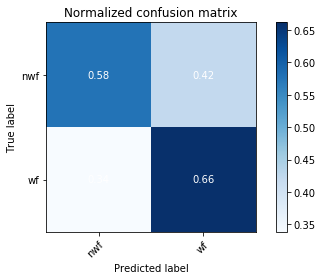

In [26]:
test_preds = test_pred_probs[:,0]>0.5
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

### precip50 + new sat feature

In [100]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut50 + new_control_features + ['sat_faparval_undefined']
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [101]:
pickle.dump(scaler, open('./Models/scaler_10pct_precip50_cwEQ_ext_fz_sat', 'wb'))

In [102]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Train on 825325 samples, validate on 418101 samples
Epoch 1/20
 - 13s - loss: 0.5665 - recall_9: 0.7476 - val_loss: 0.7072 - val_recall_9: 0.8892
Epoch 2/20
 - 12s - loss: 0.5205 - recall_9: 0.7940 - val_loss: 0.7191 - val_recall_9: 0.8950
Epoch 3/20
 - 12s - loss: 0.5060 - recall_9: 0.8052 - val_loss: 0.6475 - val_recall_9: 0.8842
Epoch 4/20
 - 13s - loss: 0.4989 - recall_9: 0.8110 - val_loss: 0.6982 - val_recall_9: 0.9020
Epoch 5/20
 - 12s - loss: 0.4933 - recall_9: 0.8136 - val_loss: 0.6433 - val_recall_9: 0.8405
Epoch 6/20
 - 12s - loss: 0.4902 - recall_9: 0.8172 - val_loss: 0.7069 - val_recall_9: 0.9067
Epoch 7/20
 - 12s - loss: 0.4868 - recall_9: 0.8201 - val_loss: 0.6950 - val_recall_9: 0.8969
Epoch 8/20
 - 12s - loss: 0.4855 - recall_9: 0.8200 - val_loss: 0.7234 - val_recall_9: 0.9004
Epoch 9/20
 - 12s - loss: 0.4834 - recall_9: 0.8224 - val_loss: 0.6870 - val_recall_9: 0.9044
Epoch 10/20
 - 12s - loss: 0.4829 - recall_9: 0.8215 - val_loss: 0.7041 - val_recall_9: 0.9036
Epoch 1

In [103]:
model_mlp.save('./Models/mlp_adam_precip50_cwEQ_ext_fz_sat.h5')

In [104]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000223    6.0  26937  0.049603
2    0.000720   17.0  23603  0.150749
3    0.001398   46.0  32915  0.254190
4    0.001509   77.0  51020  0.352705
5    0.002549  163.0  63946  0.451136
6    0.003026  192.0  63457  0.549901
7    0.004810  296.0  61537  0.649494
8    0.004990  325.0  65135  0.748529
9    0.003945  111.0  28137  0.835962
10   0.006410    9.0   1404  0.920287
11   0.000000    0.0     10  1.000000

Confusion matrix, without normalization
[[198112 218747]
 [   309    933]]
              precision    recall  f1-score   support

         nwf       1.00      0.48      0.64    416859
          wf       0.00      0.75      0.01      1242

   micro avg       0.48      0.48      0.48    418101
   macro avg       0.50      0.61      0.33    418101
weighted avg       1.00      0.48      0.64    418101



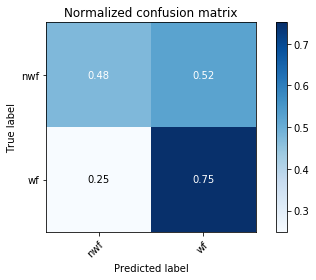

In [105]:
test_preds = test_pred_probs[:,0]>0.5
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)